## Task 1 - Part 1

#### Step 1 − Import the necessary packages

In [14]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels import robust
from numpy.linalg import lstsq




#### Step 1.5 − Aux Regressor Matrix

In [15]:
def build_regressor_matrix(y_train, u_train, n, m, d):
    N = len(y_train)
    p = max(n, d + m)  # start point for regressor matrix
    
    # Initialize the regressor matrix X and output vector Y
    X = []
    Y = []
    
    for k in range(p, N):
        # Collect past outputs y(k-1), y(k-2), ..., y(k-n)
        y_terms = [-y_train[k-i] for i in range(1, n+1)]
        
        # Collect delayed inputs u(k-d), u(k-d-1), ..., u(k-d-m)
        u_terms = [u_train[k-d-i] for i in range(m+1)]
        
        # Form the regressor vector ϕ(k)
        phi_k = y_terms + u_terms
        X.append(phi_k)
        
        # Corresponding output y(k)
        Y.append(y_train[k])
    
    return np.array(X), np.array(Y)

#### Step 1 − Aux estimate parameters leastsquares

In [16]:
def estimate_parameters(X, Y):
    # Solve for θ using least squares
    theta, residuals, rank, s = lstsq(X, Y, rcond=None)
    return theta

#### Step 1 − Aux estimate parameters for regularization

In [17]:
def estimate_parameters_ridge(X, Y, alpha):
    # Use Ridge regression with the given alpha (regularization strength)
    ridge_reg = Ridge(alpha=alpha, fit_intercept=False)
    ridge_reg.fit(X, Y)
    return ridge_reg.coef_

In [18]:
def estimate_parameters_lasso(X, Y, alpha):
    # Use Ridge regression with the given alpha (regularization strength)
    lasso_reg = Lasso(alpha=alpha, fit_intercept=False,  max_iter=20000, tol=1e-3)
    lasso_reg.fit(X, Y)
    return lasso_reg.coef_

In [19]:
def estimate_parameters_elastic(X, Y, alpha):
    # Use Ridge regression with the given alpha (regularization strength)
    elastic_reg = ElasticNet(alpha=alpha, fit_intercept=False,  max_iter=20000, tol=1e-3)
    elastic_reg.fit(X, Y)
    return elastic_reg.coef_

#### Step 1 − Aux predict ARX

In [20]:
def predict_arx(theta, y_train_scaled, u_test_scaled, n, m, d):
    N_test = len(u_test_scaled)
    y_pred_scaled = np.zeros(N_test)
    
    # Use the final part of y_train_scaled for initialization (history)
    y_history = list(y_train_scaled[-n:])  # Ensure this uses exactly `n` history points
    
    for k in range(N_test):
        # Collect past outputs from y_pred_scaled (y(k-1), ..., y(k-n))
        y_terms = [-y_history[-i] for i in range(1, n+1)]  # exactly `n` terms
        
        # Collect delayed inputs from u_test_scaled (u(k-d), ..., u(k-d-m))
        if k >= d:
            u_terms = [u_test_scaled[k-d-i] for i in range(m+1)]  # exactly `m+1` terms
        else:
            u_terms = [0] * (m+1)  # For early k values where we don't have enough history
        
        # Form ϕ(k) with `n` y_terms and `m+1` u_terms
        phi_k = np.array(y_terms + u_terms)  # Total length: n + m + 1
        
        # Predict y(k) in the scaled space
        y_pred_scaled[k] = np.dot(phi_k, theta)
        
        # Update history with the new scaled prediction
        y_history.append(y_pred_scaled[k])
    
    return y_pred_scaled


#### Step 1 − Aux split data

In [21]:
def split_data(u_train, y_train, split_ratio=0.7):
    split_index = int(len(u_train) * split_ratio)
    
    # Training set
    u_train_sub = u_train[:split_index]
    y_train_sub = y_train[:split_index]
    
    # Validation set
    u_val = u_train[split_index:]
    y_val = y_train[split_index:]
    
    return u_train_sub, y_train_sub, u_val, y_val

#### Step 2 − Load the dataset

In [22]:
# import data:
y_train = np.load('output_train.npy')
u_test = np.load('u_test.npy')
u_train = np.load('u_train.npy')

print(y_train.shape)
print(u_test.shape)
print(u_train.shape)



(2040,)
(510,)
(2040,)


#### Step 3 − Scaling

In [23]:
def scale_data(u_train, y_train, u_val, u_test, y_val):
    # Create scalers for input and output
    input_scaler = MinMaxScaler()
    output_scaler = MinMaxScaler()
    
    # Fit and transform the input and output training data
    u_train_scaled = input_scaler.fit_transform(u_train.reshape(-1, 1)).flatten()  # Reshape for scaling
    y_train_scaled = output_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    
    # Scale the validation and test sets if provided
    u_val_scaled = input_scaler.transform(u_val.reshape(-1, 1)).flatten() 
    u_test_scaled = input_scaler.transform(u_test.reshape(-1, 1)).flatten() 

    # Scale the validation output
    y_val_scaled = output_scaler.transform(y_val.reshape(-1, 1)).flatten()
    
    return u_train_scaled, y_train_scaled, u_val_scaled, u_test_scaled, y_val_scaled, input_scaler, output_scaler

#### Step 3 − Plot the trainning features and outputs

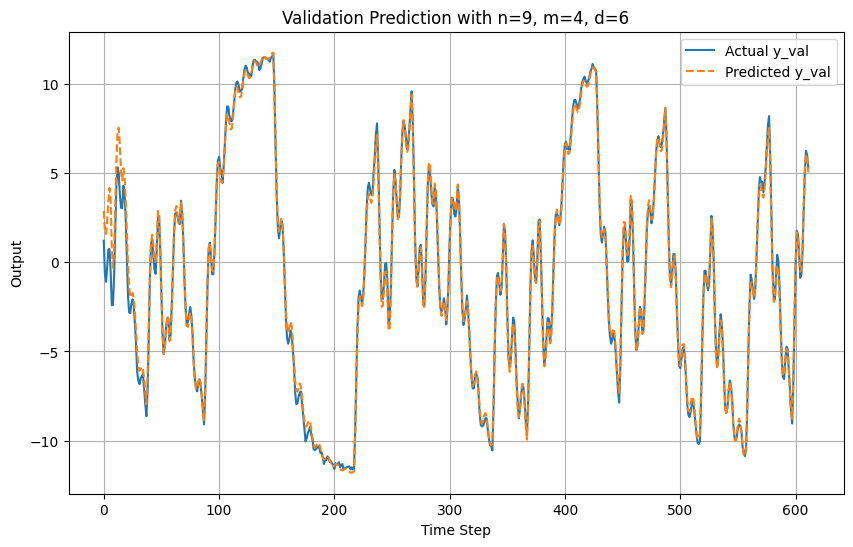

Validation MSE: 0.2638232040764549


In [24]:
n=9
m=4
d=6


u_train_sub, y_train_sub, u_val, y_val = split_data(u_train, y_train)
    
# Build the regressor matrix and output vector for the training subset
X_train_sub, Y_train_sub = build_regressor_matrix(y_train_sub, u_train_sub, n, m, d)

# Estimate the parameters on the training subset
theta = estimate_parameters(X_train_sub, Y_train_sub)

# Predict on the validation set
y_pred_val = predict_arx(theta, y_val, u_val, n, m, d)

# Plot validation predictions
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual y_val')
plt.plot(y_pred_val, label='Predicted y_val', linestyle='--')
plt.title(f"Validation Prediction with n={n}, m={m}, d={d}")
plt.xlabel('Time Step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

# Compute MSE for the validation set
# Compute MSE using the original scale
mse_val=mean_squared_error(y_val, y_pred_val)
print(f"Validation MSE: {mse_val}")

Validation MSE: 0.09267537960995381


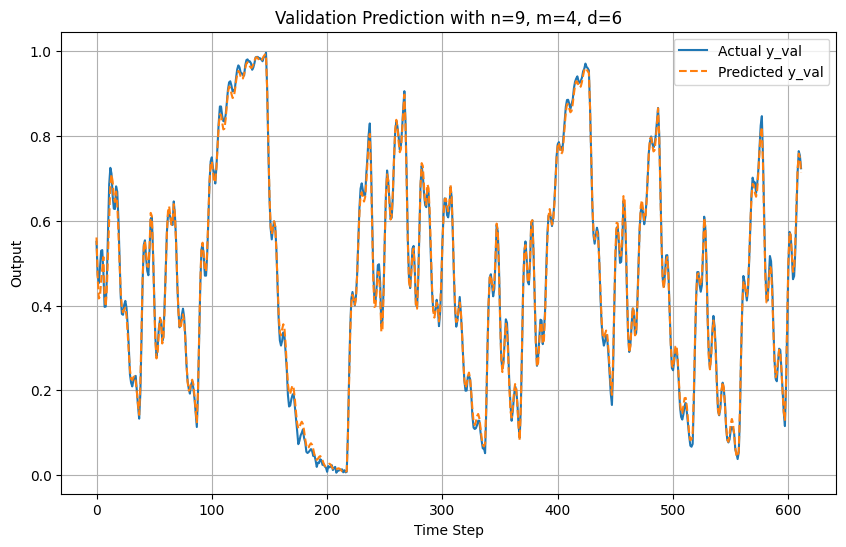

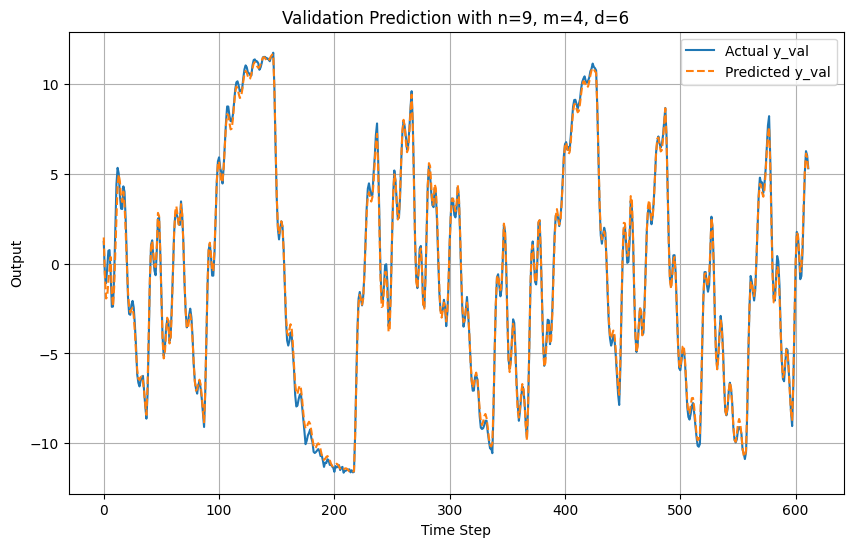

In [25]:
n=9
m=4
d=6


u_train_sub, y_train_sub, u_val, y_val = split_data(u_train, y_train)



# Scale the data
u_train_scaled, y_train_scaled, u_val_scaled, u_test_scaled,y_val_scaled, input_scaler, output_scaler = scale_data(u_train_sub, y_train_sub, u_val, u_test, y_val)

# Build the regressor matrix using scaled data
X_train_sub, Y_train_sub = build_regressor_matrix(y_train_scaled, u_train_scaled, n, m, d)

# Estimate the parameters (theta) using the scaled data
theta = estimate_parameters(X_train_sub, Y_train_sub)

# Predict on the validation set in the scaled domain
y_pred_val_scaled = predict_arx(theta, y_val_scaled, u_val_scaled, n, m, d)

# Inverse transform the predictions to get them back to the original scale
y_pred_val = output_scaler.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).flatten()

# Compute MSE using the original scale
mse_val=mean_squared_error(y_val, y_pred_val)
print(f"Validation MSE: {mse_val}")

# Plot validation predictions
plt.figure(figsize=(10, 6))
plt.plot(y_val_scaled, label='Actual y_val')
plt.plot(y_pred_val_scaled, label='Predicted y_val', linestyle='--')
plt.title(f"Validation Prediction with n={n}, m={m}, d={d}")
plt.xlabel('Time Step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation predictions
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual y_val')
plt.plot(y_pred_val, label='Predicted y_val', linestyle='--')
plt.title(f"Validation Prediction with n={n}, m={m}, d={d}")
plt.xlabel('Time Step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()


Tune ARX


Trying n=0, m=0, d=0
Validation MSE: 39.170424649583566

Trying n=0, m=0, d=1
Validation MSE: 37.78551416843278

Trying n=0, m=0, d=2
Validation MSE: 36.009393999991744

Trying n=0, m=0, d=3
Validation MSE: 33.89034854155655

Trying n=0, m=0, d=4
Validation MSE: 31.259063934489117

Trying n=0, m=0, d=5
Validation MSE: 27.665104433560224

Trying n=0, m=0, d=6
Validation MSE: 22.579927561210184

Trying n=0, m=0, d=7
Validation MSE: 17.7566762258827

Trying n=0, m=0, d=8
Validation MSE: 14.888450851127622

Trying n=0, m=0, d=9
Validation MSE: 14.719879227397149

Trying n=0, m=1, d=0
Validation MSE: 37.213261698816844

Trying n=0, m=1, d=1
Validation MSE: 35.6991617373492

Trying n=0, m=1, d=2
Validation MSE: 33.74775242314578

Trying n=0, m=1, d=3
Validation MSE: 31.169405998763715

Trying n=0, m=1, d=4
Validation MSE: 27.544149336468774

Trying n=0, m=1, d=5
Validation MSE: 22.395525049533997

Trying n=0, m=1, d=6
Validation MSE: 17.803855752964946

Trying n=0, m=1, d=7
Validation MSE: 

/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)


Validation MSE: 0.4874417841233563

Trying n=8, m=9, d=7
Validation MSE: 0.8121890212300178

Trying n=8, m=9, d=8
Validation MSE: 3.0750983030902997e+302

Trying n=8, m=9, d=9
Validation MSE: 7668.571427046202

Trying n=9, m=0, d=0
Validation MSE: 5.30787533001813

Trying n=9, m=0, d=1
Validation MSE: 4.477352774990793

Trying n=9, m=0, d=2
Validation MSE: 3.9828447423312663

Trying n=9, m=0, d=3
Validation MSE: 3.214082746039996

Trying n=9, m=0, d=4
Validation MSE: 1.9759827036240751

Trying n=9, m=0, d=5
Validation MSE: 0.7767527152144084

Trying n=9, m=0, d=6
Validation MSE: 0.3623257190775038

Trying n=9, m=0, d=7
Validation MSE: 1.0677851213954808

Trying n=9, m=0, d=8
Validation MSE: 4.22239298845781e+128

Trying n=9, m=0, d=9
Validation MSE: 235.99315566711152

Trying n=9, m=1, d=0
Validation MSE: 4.4613970746589215

Trying n=9, m=1, d=1
Validation MSE: 3.981721067681099

Trying n=9, m=1, d=2
Validation MSE: 3.2260718841562674

Trying n=9, m=1, d=3
Validation MSE: 2.25317577160

/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)


Validation MSE: 0.6347249687585147

Trying n=9, m=8, d=5
Validation MSE: 0.5329382059430714

Trying n=9, m=8, d=6
Validation MSE: 0.4375780593737197

Trying n=9, m=8, d=7
Validation MSE: 0.749731629034092

Trying n=9, m=8, d=8
Validation MSE: inf

Trying n=9, m=8, d=9
Validation MSE: 34.629620455195656

Trying n=9, m=9, d=0
Validation MSE: 1.4157996272037974

Trying n=9, m=9, d=1
Validation MSE: 1.109011084393072

Trying n=9, m=9, d=2
Validation MSE: 1.040591243047671

Trying n=9, m=9, d=3
Validation MSE: 0.800864612179389

Trying n=9, m=9, d=4
Validation MSE: 0.687591387685116

Trying n=9, m=9, d=5
Validation MSE: 0.5733901767164312

Trying n=9, m=9, d=6
Validation MSE: 0.4665954816288025

Trying n=9, m=9, d=7
Validation MSE: 0.8996771812407505

Trying n=9, m=9, d=8
Validation MSE: inf

Trying n=9, m=9, d=9
Validation MSE: 18.298870555673286

Best parameters: n=4, m=7, d=6 with Validation MSE: 0.2345856097418204


/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)


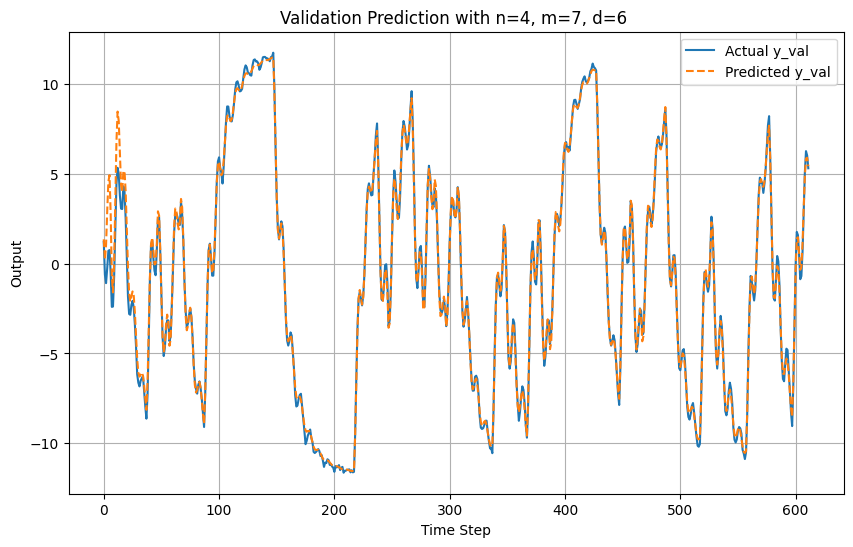

Validation SSE: 0.2345856097418204


In [26]:
best_sse = float('inf')
best_params = (None, None, None)
best_pred = None

# Try different values of n, m, d
for n in range(0, 10):  # Change range based on experimentation
    for m in range(0, 10):
        for d in range(0, 10):
            print(f"\nTrying n={n}, m={m}, d={d}")
            u_train_sub, y_train_sub, u_val, y_val = split_data(u_train, y_train)
    
            # Build the regressor matrix and output vector for the training subset
            X_train_sub, Y_train_sub = build_regressor_matrix(y_train_sub, u_train_sub, n, m, d)

            # Estimate the parameters on the training subset
            theta = estimate_parameters(X_train_sub, Y_train_sub)

            # Predict on the validation set
            y_pred_val = predict_arx(theta, y_train_sub, u_val, n, m, d)
            
            # Compute MSE using the original scale
            mse_val=mean_squared_error(y_val, y_pred_val)
            print(f"Validation MSE: {mse_val}")
            # Track the best model based on validation MSE
            if mse_val < best_sse:
                best_sse = mse_val
                best_params = (n, m, d)
               
                

print(f"\nBest parameters: n={best_params[0]}, m={best_params[1]}, d={best_params[2]} with Validation MSE: {best_sse}")

u_train_sub, y_train_sub, u_val, y_val = split_data(u_train, y_train)
    
# Build the regressor matrix and output vector for the training subset
X_train_sub, Y_train_sub = build_regressor_matrix(y_train_sub, u_train_sub, best_params[0], best_params[1], best_params[2])

# Estimate the parameters on the training subset
theta = estimate_parameters(X_train_sub, Y_train_sub)

# Predict on the validation set
y_pred_val = predict_arx(theta, y_train_sub, u_val, best_params[0], best_params[1], best_params[2])

# Plot validation predictions
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual y_val')
plt.plot(y_pred_val, label='Predicted y_val', linestyle='--')
plt.title(f"Validation Prediction with n={best_params[0]}, m={best_params[1]}, d={best_params[2]} ")
plt.xlabel('Time Step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

# Compute SSE using the original scale
mse_val=mean_squared_error(y_val, y_pred_val)
print(f"Validation SSE: {mse_val}")






Trying n=0, m=0, d=1

Trying n=0, m=0, d=2

Trying n=0, m=0, d=3

Trying n=0, m=0, d=4

Trying n=0, m=0, d=5

Trying n=0, m=0, d=6

Trying n=0, m=0, d=7

Trying n=0, m=0, d=8

Trying n=0, m=0, d=9

Trying n=0, m=1, d=1

Trying n=0, m=1, d=2

Trying n=0, m=1, d=3

Trying n=0, m=1, d=4

Trying n=0, m=1, d=5

Trying n=0, m=1, d=6

Trying n=0, m=1, d=7

Trying n=0, m=1, d=8

Trying n=0, m=1, d=9

Trying n=0, m=2, d=1

Trying n=0, m=2, d=2

Trying n=0, m=2, d=3

Trying n=0, m=2, d=4

Trying n=0, m=2, d=5

Trying n=0, m=2, d=6

Trying n=0, m=2, d=7

Trying n=0, m=2, d=8

Trying n=0, m=2, d=9

Trying n=0, m=3, d=1

Trying n=0, m=3, d=2

Trying n=0, m=3, d=3

Trying n=0, m=3, d=4

Trying n=0, m=3, d=5

Trying n=0, m=3, d=6

Trying n=0, m=3, d=7

Trying n=0, m=3, d=8

Trying n=0, m=3, d=9

Trying n=0, m=4, d=1

Trying n=0, m=4, d=2

Trying n=0, m=4, d=3

Trying n=0, m=4, d=4

Trying n=0, m=4, d=5

Trying n=0, m=4, d=6

Trying n=0, m=4, d=7

Trying n=0, m=4, d=8

Trying n=0, m=4, d=9

Trying n=

/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/home/olivas/.local/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)



Trying n=8, m=9, d=2

Trying n=8, m=9, d=3

Trying n=8, m=9, d=4

Trying n=8, m=9, d=5

Trying n=8, m=9, d=6

Trying n=8, m=9, d=7

Trying n=8, m=9, d=8

Trying n=8, m=9, d=9

Trying n=9, m=0, d=1

Trying n=9, m=0, d=2

Trying n=9, m=0, d=3

Trying n=9, m=0, d=4

Trying n=9, m=0, d=5

Trying n=9, m=0, d=6

Trying n=9, m=0, d=7

Trying n=9, m=0, d=8

Trying n=9, m=0, d=9

Trying n=9, m=1, d=1

Trying n=9, m=1, d=2

Trying n=9, m=1, d=3

Trying n=9, m=1, d=4

Trying n=9, m=1, d=5

Trying n=9, m=1, d=6

Trying n=9, m=1, d=7

Trying n=9, m=1, d=8

Trying n=9, m=1, d=9

Trying n=9, m=2, d=1

Trying n=9, m=2, d=2

Trying n=9, m=2, d=3

Trying n=9, m=2, d=4

Trying n=9, m=2, d=5

Trying n=9, m=2, d=6

Trying n=9, m=2, d=7

Trying n=9, m=2, d=8

Trying n=9, m=2, d=9

Trying n=9, m=3, d=1

Trying n=9, m=3, d=2

Trying n=9, m=3, d=3

Trying n=9, m=3, d=4

Trying n=9, m=3, d=5

Trying n=9, m=3, d=6

Trying n=9, m=3, d=7

Trying n=9, m=3, d=8

Trying n=9, m=3, d=9

Trying n=9, m=4, d=1

Trying n=

/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)



Trying n=9, m=8, d=8

Trying n=9, m=8, d=9

Trying n=9, m=9, d=1

Trying n=9, m=9, d=2

Trying n=9, m=9, d=3

Trying n=9, m=9, d=4

Trying n=9, m=9, d=5

Trying n=9, m=9, d=6

Trying n=9, m=9, d=7

Trying n=9, m=9, d=8

Trying n=9, m=9, d=9

Best parameters: n=9, m=6, d=6 with Validation SSE: 0.0672166652536147


/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)


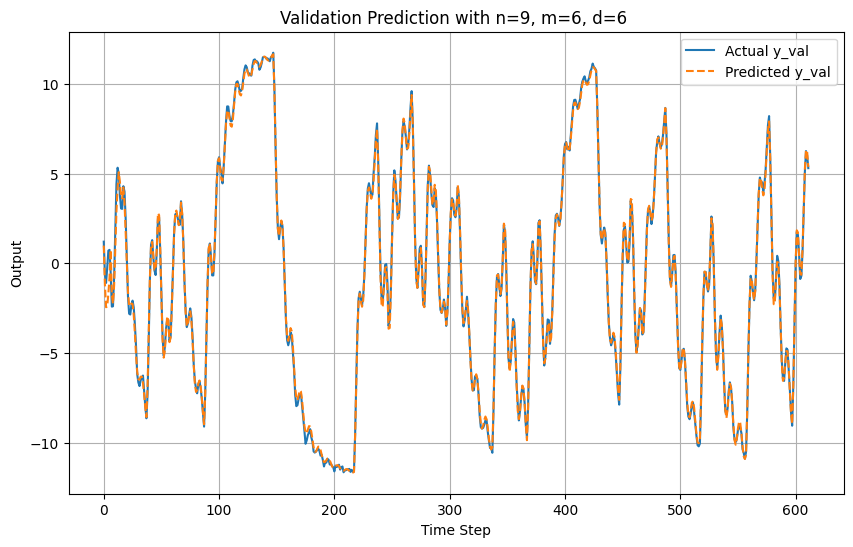

Validation SSE: 0.0672166652536147


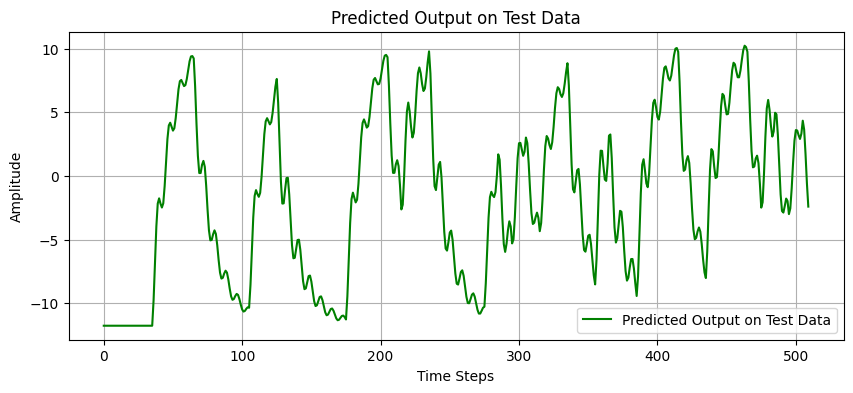

-2.4070390126080463
-2.4070390126080463
(510,)
(400,)


In [27]:
best_sse = float('inf')
best_params = (None, None, None)
best_pred = None

u_train_sub, y_train_sub, u_val, y_val = split_data(u_train, y_train)


            # Scale the data
u_train_scaled, y_train_scaled, u_val_scaled, u_test_scaled,y_val_scaled,  input_scaler, output_scaler = scale_data(u_train_sub, y_train_sub, u_val, u_test, y_val)
            

# Try different values of n, m, d
for n in range(0, 10):  # Change range based on experimentation
    for m in range(0, 10):
        for d in range(1, 10):
            print(f"\nTrying n={n}, m={m}, d={d}")
        
            # Build the regressor matrix and output vector for the training subset
            X_train_sub, Y_train_sub = build_regressor_matrix(y_train_scaled, u_train_scaled, n, m, d)

            # Estimate the parameters on the training subset
            theta = estimate_parameters(X_train_sub, Y_train_sub)

            # Predict on the validation set
            y_pred_val_scaled = predict_arx(theta, y_val_scaled, u_val_scaled, n, m, d)

            # Inverse transform the predictions to the original scale
            y_pred_val = output_scaler.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).flatten()
            
            # Compute SSE using the original scale
            mse_val=mean_squared_error(y_val, y_pred_val)
            
            # Track the best model based on validation SSE
            if mse_val < best_sse:
                best_sse = mse_val
                best_params = (n, m, d)
               
                

print(f"\nBest parameters: n={best_params[0]}, m={best_params[1]}, d={best_params[2]} with Validation SSE: {best_sse}")


# Build the regressor matrix and output vector for the training subset
X_train_sub, Y_train_sub = build_regressor_matrix(y_train_scaled, u_train_scaled, best_params[0], best_params[1], best_params[2])

# Estimate the parameters on the training subset
theta = estimate_parameters(X_train_sub, Y_train_sub)


# Predict on the validation set
y_pred_val_scaled = predict_arx(theta, y_val_scaled, u_val_scaled, best_params[0], best_params[1], best_params[2])

# Inverse transform the predictions to the original scale
y_pred_val = output_scaler.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).flatten()

# Plot validation predictions
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual y_val')
plt.plot(y_pred_val, label='Predicted y_val', linestyle='--')
plt.title(f"Validation Prediction with n={best_params[0]}, m={best_params[1]}, d={best_params[2]} ")
plt.xlabel('Time Step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

# Compute SSE for the validation set
mse_val=mean_squared_error(y_val, y_pred_val)
print(f"Validation SSE: {mse_val}")

n_best = best_params[0]
m_best = best_params[1]
d_best = best_params[2]


# Step 2: Predict using the trained model on the u_test data
y_pred_test_scaled = predict_arx(theta, np.zeros(n), u_test_scaled, n_best, m_best, d_best)


# Step 3: Inverse transform the predicted output to original scale
y_pred_test = output_scaler.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()


# Plot the predicted output for the test input
plt.figure(figsize=(10, 4))
plt.plot(y_pred_test, label="Predicted Output on Test Data", color='green')
plt.title("Predicted Output on Test Data")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


y_pred_final =y_pred_test[-400:]
print(y_pred_test[-1])
print(y_pred_final[-1])
print(y_pred_test.shape)
print(y_pred_final.shape)
# save ypred_test as .txt file:
np.save('ytest_pred', y_pred_final)





Trying n=0, m=0, d=1

Trying n=0, m=0, d=2

Trying n=0, m=0, d=3

Trying n=0, m=0, d=4

Trying n=0, m=0, d=5

Trying n=0, m=0, d=6

Trying n=0, m=0, d=7

Trying n=0, m=0, d=8

Trying n=0, m=0, d=9

Trying n=0, m=1, d=1

Trying n=0, m=1, d=2

Trying n=0, m=1, d=3

Trying n=0, m=1, d=4

Trying n=0, m=1, d=5

Trying n=0, m=1, d=6

Trying n=0, m=1, d=7

Trying n=0, m=1, d=8

Trying n=0, m=1, d=9

Trying n=0, m=2, d=1

Trying n=0, m=2, d=2

Trying n=0, m=2, d=3

Trying n=0, m=2, d=4

Trying n=0, m=2, d=5

Trying n=0, m=2, d=6

Trying n=0, m=2, d=7

Trying n=0, m=2, d=8

Trying n=0, m=2, d=9

Trying n=0, m=3, d=1

Trying n=0, m=3, d=2

Trying n=0, m=3, d=3

Trying n=0, m=3, d=4

Trying n=0, m=3, d=5

Trying n=0, m=3, d=6

Trying n=0, m=3, d=7

Trying n=0, m=3, d=8

Trying n=0, m=3, d=9

Trying n=0, m=4, d=1

Trying n=0, m=4, d=2

Trying n=0, m=4, d=3

Trying n=0, m=4, d=4

Trying n=0, m=4, d=5

Trying n=0, m=4, d=6

Trying n=0, m=4, d=7

Trying n=0, m=4, d=8

Trying n=0, m=4, d=9

Trying n=

/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)



Trying n=8, m=9, d=7

Trying n=8, m=9, d=8

Trying n=8, m=9, d=9

Trying n=9, m=0, d=1

Trying n=9, m=0, d=2

Trying n=9, m=0, d=3

Trying n=9, m=0, d=4

Trying n=9, m=0, d=5

Trying n=9, m=0, d=6

Trying n=9, m=0, d=7

Trying n=9, m=0, d=8

Trying n=9, m=0, d=9

Trying n=9, m=1, d=1

Trying n=9, m=1, d=2

Trying n=9, m=1, d=3

Trying n=9, m=1, d=4

Trying n=9, m=1, d=5

Trying n=9, m=1, d=6

Trying n=9, m=1, d=7

Trying n=9, m=1, d=8

Trying n=9, m=1, d=9

Trying n=9, m=2, d=1

Trying n=9, m=2, d=2

Trying n=9, m=2, d=3

Trying n=9, m=2, d=4

Trying n=9, m=2, d=5

Trying n=9, m=2, d=6

Trying n=9, m=2, d=7

Trying n=9, m=2, d=8

Trying n=9, m=2, d=9

Trying n=9, m=3, d=1

Trying n=9, m=3, d=2

Trying n=9, m=3, d=3

Trying n=9, m=3, d=4

Trying n=9, m=3, d=5

Trying n=9, m=3, d=6

Trying n=9, m=3, d=7

Trying n=9, m=3, d=8

Trying n=9, m=3, d=9

Trying n=9, m=4, d=1

Trying n=9, m=4, d=2

Trying n=9, m=4, d=3

Trying n=9, m=4, d=4

Trying n=9, m=4, d=5

Trying n=9, m=4, d=6

Trying n=

/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)



Trying n=9, m=9, d=3

Trying n=9, m=9, d=4

Trying n=9, m=9, d=5

Trying n=9, m=9, d=6

Trying n=9, m=9, d=7

Trying n=9, m=9, d=8

Trying n=9, m=9, d=9

Trying n=0, m=0, d=1

Trying n=0, m=0, d=2

Trying n=0, m=0, d=3

Trying n=0, m=0, d=4

Trying n=0, m=0, d=5

Trying n=0, m=0, d=6

Trying n=0, m=0, d=7

Trying n=0, m=0, d=8

Trying n=0, m=0, d=9

Trying n=0, m=1, d=1

Trying n=0, m=1, d=2

Trying n=0, m=1, d=3

Trying n=0, m=1, d=4


/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)



Trying n=0, m=1, d=5

Trying n=0, m=1, d=6

Trying n=0, m=1, d=7

Trying n=0, m=1, d=8

Trying n=0, m=1, d=9

Trying n=0, m=2, d=1

Trying n=0, m=2, d=2

Trying n=0, m=2, d=3

Trying n=0, m=2, d=4

Trying n=0, m=2, d=5

Trying n=0, m=2, d=6

Trying n=0, m=2, d=7

Trying n=0, m=2, d=8

Trying n=0, m=2, d=9

Trying n=0, m=3, d=1

Trying n=0, m=3, d=2

Trying n=0, m=3, d=3

Trying n=0, m=3, d=4

Trying n=0, m=3, d=5

Trying n=0, m=3, d=6

Trying n=0, m=3, d=7

Trying n=0, m=3, d=8

Trying n=0, m=3, d=9

Trying n=0, m=4, d=1

Trying n=0, m=4, d=2

Trying n=0, m=4, d=3

Trying n=0, m=4, d=4

Trying n=0, m=4, d=5

Trying n=0, m=4, d=6

Trying n=0, m=4, d=7

Trying n=0, m=4, d=8

Trying n=0, m=4, d=9

Trying n=0, m=5, d=1

Trying n=0, m=5, d=2

Trying n=0, m=5, d=3

Trying n=0, m=5, d=4

Trying n=0, m=5, d=5

Trying n=0, m=5, d=6

Trying n=0, m=5, d=7

Trying n=0, m=5, d=8

Trying n=0, m=5, d=9

Trying n=0, m=6, d=1

Trying n=0, m=6, d=2

Trying n=0, m=6, d=3

Trying n=0, m=6, d=4

Trying n=

/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)



Trying n=8, m=9, d=8

Trying n=8, m=9, d=9

Trying n=9, m=0, d=1

Trying n=9, m=0, d=2

Trying n=9, m=0, d=3

Trying n=9, m=0, d=4

Trying n=9, m=0, d=5

Trying n=9, m=0, d=6

Trying n=9, m=0, d=7

Trying n=9, m=0, d=8

Trying n=9, m=0, d=9

Trying n=9, m=1, d=1

Trying n=9, m=1, d=2

Trying n=9, m=1, d=3

Trying n=9, m=1, d=4

Trying n=9, m=1, d=5

Trying n=9, m=1, d=6

Trying n=9, m=1, d=7

Trying n=9, m=1, d=8

Trying n=9, m=1, d=9

Trying n=9, m=2, d=1

Trying n=9, m=2, d=2

Trying n=9, m=2, d=3

Trying n=9, m=2, d=4

Trying n=9, m=2, d=5

Trying n=9, m=2, d=6

Trying n=9, m=2, d=7

Trying n=9, m=2, d=8

Trying n=9, m=2, d=9

Trying n=9, m=3, d=1

Trying n=9, m=3, d=2

Trying n=9, m=3, d=3

Trying n=9, m=3, d=4

Trying n=9, m=3, d=5

Trying n=9, m=3, d=6

Trying n=9, m=3, d=7

Trying n=9, m=3, d=8

Trying n=9, m=3, d=9

Trying n=9, m=4, d=1

Trying n=9, m=4, d=2

Trying n=9, m=4, d=3

Trying n=9, m=4, d=4

Trying n=9, m=4, d=5

Trying n=9, m=4, d=6

Trying n=9, m=4, d=7

Trying n=

/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)



Trying n=9, m=9, d=3

Trying n=9, m=9, d=4

Trying n=9, m=9, d=5

Trying n=9, m=9, d=6

Trying n=9, m=9, d=7

Trying n=9, m=9, d=8

Trying n=9, m=9, d=9

Trying n=0, m=0, d=1

Trying n=0, m=0, d=2

Trying n=0, m=0, d=3

Trying n=0, m=0, d=4

Trying n=0, m=0, d=5

Trying n=0, m=0, d=6

Trying n=0, m=0, d=7

Trying n=0, m=0, d=8

Trying n=0, m=0, d=9

Trying n=0, m=1, d=1

Trying n=0, m=1, d=2

Trying n=0, m=1, d=3

Trying n=0, m=1, d=4

Trying n=0, m=1, d=5

Trying n=0, m=1, d=6


/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)



Trying n=0, m=1, d=7

Trying n=0, m=1, d=8

Trying n=0, m=1, d=9

Trying n=0, m=2, d=1

Trying n=0, m=2, d=2

Trying n=0, m=2, d=3

Trying n=0, m=2, d=4

Trying n=0, m=2, d=5

Trying n=0, m=2, d=6

Trying n=0, m=2, d=7

Trying n=0, m=2, d=8

Trying n=0, m=2, d=9

Trying n=0, m=3, d=1

Trying n=0, m=3, d=2

Trying n=0, m=3, d=3

Trying n=0, m=3, d=4

Trying n=0, m=3, d=5

Trying n=0, m=3, d=6

Trying n=0, m=3, d=7

Trying n=0, m=3, d=8

Trying n=0, m=3, d=9

Trying n=0, m=4, d=1

Trying n=0, m=4, d=2

Trying n=0, m=4, d=3

Trying n=0, m=4, d=4

Trying n=0, m=4, d=5

Trying n=0, m=4, d=6

Trying n=0, m=4, d=7

Trying n=0, m=4, d=8

Trying n=0, m=4, d=9

Trying n=0, m=5, d=1

Trying n=0, m=5, d=2

Trying n=0, m=5, d=3

Trying n=0, m=5, d=4

Trying n=0, m=5, d=5

Trying n=0, m=5, d=6

Trying n=0, m=5, d=7

Trying n=0, m=5, d=8

Trying n=0, m=5, d=9

Trying n=0, m=6, d=1

Trying n=0, m=6, d=2

Trying n=0, m=6, d=3

Trying n=0, m=6, d=4

Trying n=0, m=6, d=5

Trying n=0, m=6, d=6

Trying n=

/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/home/olivas/.local/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)



Trying n=9, m=9, d=4

Trying n=9, m=9, d=5

Trying n=9, m=9, d=6

Trying n=9, m=9, d=7

Trying n=9, m=9, d=8

Trying n=9, m=9, d=9

Trying n=0, m=0, d=1

Trying n=0, m=0, d=2

Trying n=0, m=0, d=3

Trying n=0, m=0, d=4

Trying n=0, m=0, d=5

Trying n=0, m=0, d=6

Trying n=0, m=0, d=7

Trying n=0, m=0, d=8

Trying n=0, m=0, d=9

Trying n=0, m=1, d=1

Trying n=0, m=1, d=2

Trying n=0, m=1, d=3

Trying n=0, m=1, d=4

Trying n=0, m=1, d=5

Trying n=0, m=1, d=6

Trying n=0, m=1, d=7

Trying n=0, m=1, d=8

Trying n=0, m=1, d=9

Trying n=0, m=2, d=1


/home/olivas/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)



Trying n=0, m=2, d=2

Trying n=0, m=2, d=3

Trying n=0, m=2, d=4

Trying n=0, m=2, d=5

Trying n=0, m=2, d=6

Trying n=0, m=2, d=7

Trying n=0, m=2, d=8

Trying n=0, m=2, d=9

Trying n=0, m=3, d=1

Trying n=0, m=3, d=2

Trying n=0, m=3, d=3

Trying n=0, m=3, d=4

Trying n=0, m=3, d=5

Trying n=0, m=3, d=6

Trying n=0, m=3, d=7

Trying n=0, m=3, d=8

Trying n=0, m=3, d=9

Trying n=0, m=4, d=1

Trying n=0, m=4, d=2

Trying n=0, m=4, d=3

Trying n=0, m=4, d=4

Trying n=0, m=4, d=5

Trying n=0, m=4, d=6

Trying n=0, m=4, d=7

Trying n=0, m=4, d=8

Trying n=0, m=4, d=9

Trying n=0, m=5, d=1

Trying n=0, m=5, d=2

Trying n=0, m=5, d=3

Trying n=0, m=5, d=4

Trying n=0, m=5, d=5

Trying n=0, m=5, d=6

Trying n=0, m=5, d=7

Trying n=0, m=5, d=8

Trying n=0, m=5, d=9

Trying n=0, m=6, d=1

Trying n=0, m=6, d=2

Trying n=0, m=6, d=3

Trying n=0, m=6, d=4

Trying n=0, m=6, d=5

Trying n=0, m=6, d=6

Trying n=0, m=6, d=7

Trying n=0, m=6, d=8

Trying n=0, m=6, d=9

Trying n=0, m=7, d=1

Trying n=

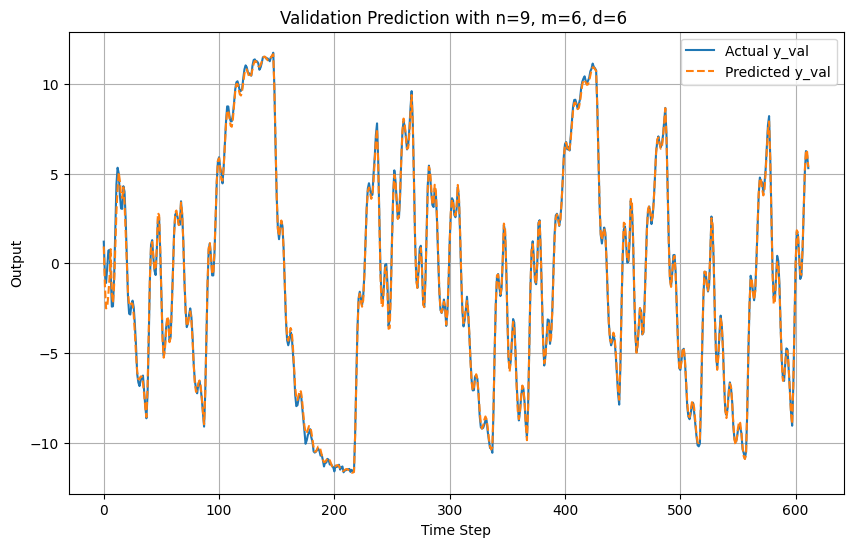

Validation SSE: 0.06976683319948097


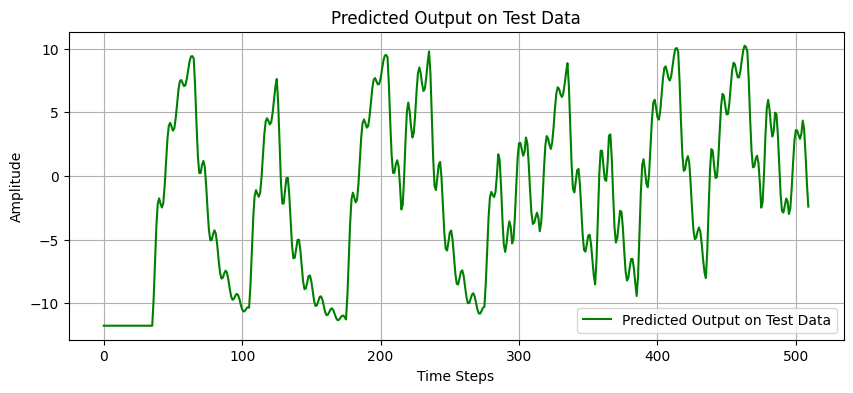

In [28]:
best_sse = float('inf')
best_params = (None, None, None)
best_pred = None
alpha_values=np.logspace(-3, 3, 10)

u_train_sub, y_train_sub, u_val, y_val = split_data(u_train, y_train)

# Scale the data
u_train_scaled, y_train_scaled, u_val_scaled, u_test_scaled,y_val_scaled,  input_scaler, output_scaler = scale_data(u_train_sub, y_train_sub, u_val, u_test, y_val)
            

# Try different values of n, m, d
for alpha in alpha_values:
    for n in range(0, 10):  # Change range based on experimentation
        for m in range(0, 10):
            for d in range(1, 10):
                print(f"\nTrying n={n}, m={m}, d={d}")
            
                # Build the regressor matrix and output vector for the training subset
                X_train_sub, Y_train_sub = build_regressor_matrix(y_train_scaled, u_train_scaled, n, m, d)

                # Estimate parameters with ridge regularization
                theta = estimate_parameters_ridge(X_train_sub, Y_train_sub, alpha)

                # Predict on the validation set
                y_pred_val_scaled = predict_arx(theta, y_val_scaled, u_val_scaled, n, m, d)

                # Inverse transform the predictions to the original scale
                y_pred_val = output_scaler.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).flatten()
                
                mse_val=mean_squared_error(y_val, y_pred_val)
                # Track the best model based on validation SSE
                if mse_val < best_sse:
                    best_sse = mse_val
                    best_params = (n, m, d, alpha)
               
                

print(f"\nBest parameters: n={best_params[0]}, m={best_params[1]}, d={best_params[2]}, alpha={best_params[3]},  with Validation SSE: {best_sse}")


# Build the regressor matrix and output vector for the training subset
X_train_sub, Y_train_sub = build_regressor_matrix(y_train_scaled, u_train_scaled, best_params[0], best_params[1], best_params[2])

# Estimate the parameters on the training subset
theta = estimate_parameters_ridge(X_train_sub, Y_train_sub, best_params[3])

# Predict on the validation set
y_pred_val_scaled = predict_arx(theta, y_val_scaled, u_val_scaled, best_params[0], best_params[1], best_params[2])

# Inverse transform the predictions to the original scale
y_pred_val = output_scaler.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).flatten()

# Plot validation predictions
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual y_val')
plt.plot(y_pred_val, label='Predicted y_val', linestyle='--')
plt.title(f"Validation Prediction with n={best_params[0]}, m={best_params[1]}, d={best_params[2]} ")
plt.xlabel('Time Step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

# Compute SSE for the validation set
mse_val = mean_squared_error(y_val, y_pred_val)
print(f"Validation SSE: {mse_val}")

n_best = best_params[0]
m_best = best_params[1]
d_best = best_params[2]
alpha_best = best_params[3]

# Step 2: Predict using the trained model on the u_test data
y_pred_test_scaled = predict_arx(theta, np.zeros(n), u_test_scaled, n_best, m_best, d_best)


# Step 3: Inverse transform the predicted output to original scale
y_pred_test = output_scaler.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()


# Inverse transform to get back to original scale
#y_pred_test = output_scaler.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()

# Plot the predicted output for the test input
plt.figure(figsize=(10, 4))
plt.plot(y_pred_test, label="Predicted Output on Test Data", color='green')
plt.title("Predicted Output on Test Data")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()






Trying n=0, m=0, d=1

Trying n=0, m=0, d=2

Trying n=0, m=0, d=3

Trying n=0, m=0, d=4

Trying n=0, m=0, d=5

Trying n=0, m=0, d=6

Trying n=0, m=0, d=7

Trying n=0, m=0, d=8

Trying n=0, m=0, d=9

Trying n=0, m=1, d=1

Trying n=0, m=1, d=2

Trying n=0, m=1, d=3

Trying n=0, m=1, d=4

Trying n=0, m=1, d=5

Trying n=0, m=1, d=6

Trying n=0, m=1, d=7

Trying n=0, m=1, d=8

Trying n=0, m=1, d=9

Trying n=0, m=2, d=1

Trying n=0, m=2, d=2

Trying n=0, m=2, d=3

Trying n=0, m=2, d=4

Trying n=0, m=2, d=5

Trying n=0, m=2, d=6

Trying n=0, m=2, d=7

Trying n=0, m=2, d=8

Trying n=0, m=2, d=9

Trying n=0, m=3, d=1

Trying n=0, m=3, d=2

Trying n=0, m=3, d=3

Trying n=0, m=3, d=4

Trying n=0, m=3, d=5

Trying n=0, m=3, d=6

Trying n=0, m=3, d=7

Trying n=0, m=3, d=8

Trying n=0, m=3, d=9

Trying n=0, m=4, d=1

Trying n=0, m=4, d=2

Trying n=0, m=4, d=3

Trying n=0, m=4, d=4

Trying n=0, m=4, d=5

Trying n=0, m=4, d=6

Trying n=0, m=4, d=7

Trying n=0, m=4, d=8

Trying n=0, m=4, d=9

Trying n=

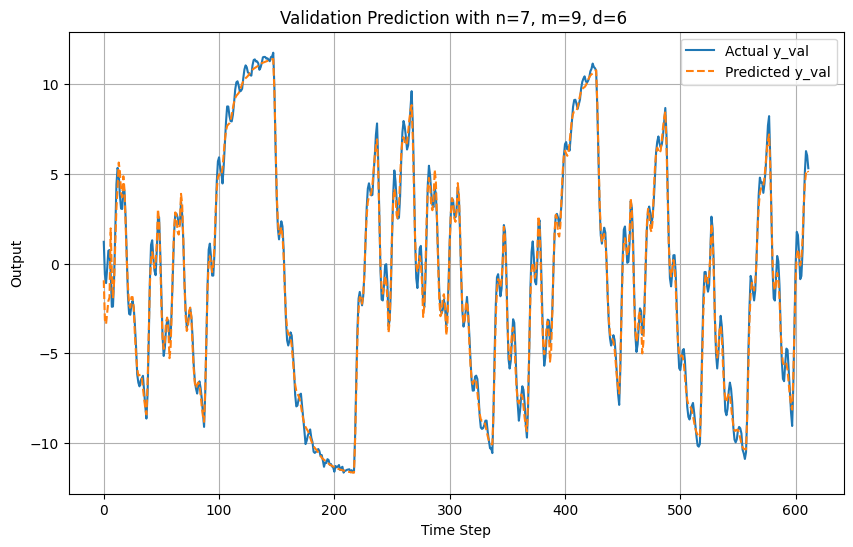

Validation SSE: 0.3181262306743669


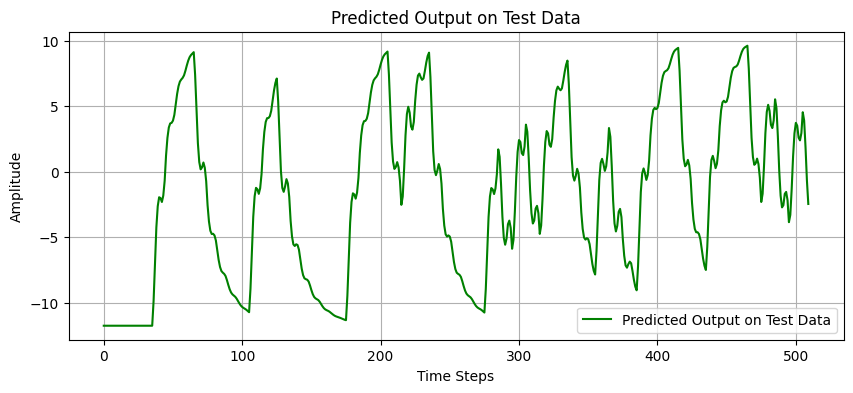

In [29]:
best_sse = float('inf')
best_params = (None, None, None)
best_pred = None
alpha_values=np.logspace(-3, 3, 10)

u_train_sub, y_train_sub, u_val, y_val = split_data(u_train, y_train)

# Scale the data
u_train_scaled, y_train_scaled, u_val_scaled, u_test_scaled,y_val_scaled,  input_scaler, output_scaler = scale_data(u_train_sub, y_train_sub, u_val, u_test, y_val)
            

# Try different values of n, m, d
for alpha in alpha_values:
    for n in range(0, 10):  # Change range based on experimentation
        for m in range(0, 10):
            for d in range(1, 10):
                print(f"\nTrying n={n}, m={m}, d={d}")
            
                # Build the regressor matrix and output vector for the training subset
                X_train_sub, Y_train_sub = build_regressor_matrix(y_train_scaled, u_train_scaled, n, m, d)

                # Estimate parameters with ridge regularization
                theta = estimate_parameters_elastic(X_train_sub, Y_train_sub, alpha)

                # Predict on the validation set
                y_pred_val_scaled = predict_arx(theta, y_val_scaled, u_val_scaled, n, m, d)

                # Inverse transform the predictions to the original scale
                y_pred_val = output_scaler.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).flatten()
                
                mse_val=mean_squared_error(y_val, y_pred_val)
                # Track the best model based on validation SSE
                if mse_val < best_sse:
                    best_sse = mse_val
                    best_params = (n, m, d, alpha)
               
                

print(f"\nBest parameters: n={best_params[0]}, m={best_params[1]}, d={best_params[2]}, alpha={best_params[3]},  with Validation SSE: {best_sse}")


# Build the regressor matrix and output vector for the training subset
X_train_sub, Y_train_sub = build_regressor_matrix(y_train_scaled, u_train_scaled, best_params[0], best_params[1], best_params[2])

# Estimate the parameters on the training subset
theta = estimate_parameters_elastic(X_train_sub, Y_train_sub, best_params[3])

# Predict on the validation set
y_pred_val_scaled = predict_arx(theta, y_val_scaled, u_val_scaled, best_params[0], best_params[1], best_params[2])

# Inverse transform the predictions to the original scale
y_pred_val = output_scaler.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).flatten()

# Plot validation predictions
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual y_val')
plt.plot(y_pred_val, label='Predicted y_val', linestyle='--')
plt.title(f"Validation Prediction with n={best_params[0]}, m={best_params[1]}, d={best_params[2]} ")
plt.xlabel('Time Step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

# Compute SSE for the validation set
mse_val = mean_squared_error(y_val, y_pred_val)
print(f"Validation SSE: {mse_val}")

n_best = best_params[0]
m_best = best_params[1]
d_best = best_params[2]
alpha_best = best_params[3]

# Step 2: Predict using the trained model on the u_test data
y_pred_test_scaled = predict_arx(theta, np.zeros(n), u_test_scaled, n_best, m_best, d_best)


# Step 3: Inverse transform the predicted output to original scale
y_pred_test = output_scaler.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()


# Inverse transform to get back to original scale
#y_pred_test = output_scaler.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()

# Plot the predicted output for the test input
plt.figure(figsize=(10, 4))
plt.plot(y_pred_test, label="Predicted Output on Test Data", color='green')
plt.title("Predicted Output on Test Data")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()





Trying n=0, m=0, d=1

Trying n=0, m=0, d=2

Trying n=0, m=0, d=3

Trying n=0, m=0, d=4

Trying n=0, m=0, d=5

Trying n=0, m=0, d=6

Trying n=0, m=0, d=7

Trying n=0, m=0, d=8

Trying n=0, m=0, d=9

Trying n=0, m=1, d=1

Trying n=0, m=1, d=2

Trying n=0, m=1, d=3

Trying n=0, m=1, d=4

Trying n=0, m=1, d=5

Trying n=0, m=1, d=6

Trying n=0, m=1, d=7

Trying n=0, m=1, d=8

Trying n=0, m=1, d=9

Trying n=0, m=2, d=1

Trying n=0, m=2, d=2

Trying n=0, m=2, d=3

Trying n=0, m=2, d=4

Trying n=0, m=2, d=5

Trying n=0, m=2, d=6

Trying n=0, m=2, d=7

Trying n=0, m=2, d=8

Trying n=0, m=2, d=9

Trying n=0, m=3, d=1

Trying n=0, m=3, d=2

Trying n=0, m=3, d=3

Trying n=0, m=3, d=4

Trying n=0, m=3, d=5

Trying n=0, m=3, d=6

Trying n=0, m=3, d=7

Trying n=0, m=3, d=8

Trying n=0, m=3, d=9

Trying n=0, m=4, d=1

Trying n=0, m=4, d=2

Trying n=0, m=4, d=3

Trying n=0, m=4, d=4

Trying n=0, m=4, d=5

Trying n=0, m=4, d=6

Trying n=0, m=4, d=7

Trying n=0, m=4, d=8

Trying n=0, m=4, d=9

Trying n=

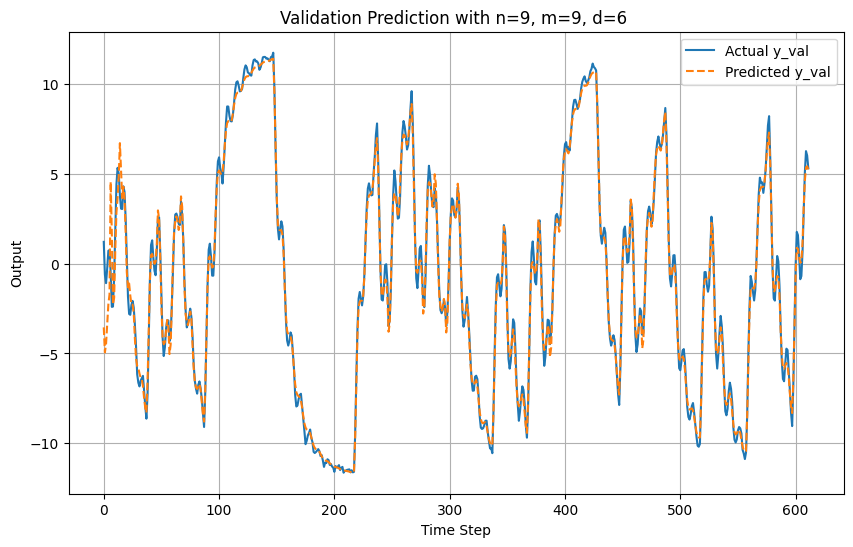

Validation SSE: 0.39618463725163133


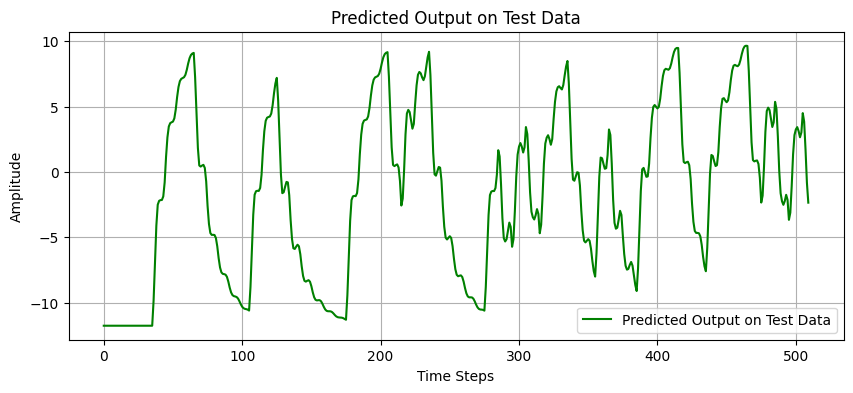

In [30]:

best_sse = float('inf')
best_params = (None, None, None)
best_pred = None
alpha_values=np.logspace(-3, 3, 10)

u_train_sub, y_train_sub, u_val, y_val = split_data(u_train, y_train)

# Scale the data
u_train_scaled, y_train_scaled, u_val_scaled, u_test_scaled,y_val_scaled,  input_scaler, output_scaler = scale_data(u_train_sub, y_train_sub, u_val, u_test, y_val)
            

# Try different values of n, m, d
for alpha in alpha_values:
    for n in range(0, 10):  # Change range based on experimentation
        for m in range(0, 10):
            for d in range(1, 10):
                print(f"\nTrying n={n}, m={m}, d={d}")
            
                # Build the regressor matrix and output vector for the training subset
                X_train_sub, Y_train_sub = build_regressor_matrix(y_train_scaled, u_train_scaled, n, m, d)

                # Estimate parameters with ridge regularization
                theta = estimate_parameters_lasso(X_train_sub, Y_train_sub, alpha)

                # Predict on the validation set
                y_pred_val_scaled = predict_arx(theta, y_val_scaled, u_val_scaled, n, m, d)

                # Inverse transform the predictions to the original scale
                y_pred_val = output_scaler.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).flatten()
                
                mse_val=mean_squared_error(y_val, y_pred_val)
                # Track the best model based on validation SSE
                if mse_val < best_sse:
                    best_sse = mse_val
                    best_params = (n, m, d, alpha)
               
                

print(f"\nBest parameters: n={best_params[0]}, m={best_params[1]}, d={best_params[2]}, alpha={best_params[3]},  with Validation SSE: {best_sse}")


# Build the regressor matrix and output vector for the training subset
X_train_sub, Y_train_sub = build_regressor_matrix(y_train_scaled, u_train_scaled, best_params[0], best_params[1], best_params[2])

# Estimate the parameters on the training subset
theta = estimate_parameters_lasso(X_train_sub, Y_train_sub, best_params[3])

# Predict on the validation set
y_pred_val_scaled = predict_arx(theta, y_val_scaled, u_val_scaled, best_params[0], best_params[1], best_params[2])

# Inverse transform the predictions to the original scale
y_pred_val = output_scaler.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).flatten()

# Plot validation predictions
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual y_val')
plt.plot(y_pred_val, label='Predicted y_val', linestyle='--')
plt.title(f"Validation Prediction with n={best_params[0]}, m={best_params[1]}, d={best_params[2]} ")
plt.xlabel('Time Step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

# Compute SSE for the validation set
mse_val = mean_squared_error(y_val, y_pred_val)
print(f"Validation SSE: {mse_val}")

n_best = best_params[0]
m_best = best_params[1]
d_best = best_params[2]
alpha_best = best_params[3]

# Step 2: Predict using the trained model on the u_test data
y_pred_test_scaled = predict_arx(theta, np.zeros(n), u_test_scaled, n_best, m_best, d_best)


# Step 3: Inverse transform the predicted output to original scale
y_pred_test = output_scaler.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()


# Inverse transform to get back to original scale
#y_pred_test = output_scaler.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()

# Plot the predicted output for the test input
plt.figure(figsize=(10, 4))
plt.plot(y_pred_test, label="Predicted Output on Test Data", color='green')
plt.title("Predicted Output on Test Data")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


